
# Next Experiment: Black‑Box Complexity vs. Ground‑Truth Chaos (Duffing Oscillator)

**Goal:** Validate that black‑box complexity metrics align with established chaos diagnostics on a canonical chaotic system. We will:

- Simulate a **driven Duffing oscillator** across a dense range of drive amplitudes (\(\gamma\)).
- Compute **ground‑truth chaos markers**: Largest Lyapunov Exponent (LLE, Rosenstein) and **0–1 test for chaos**.
- Compute **black‑box metrics** from the observable (output) only: **Lempel–Ziv (LZ) complexity**, **recurrence rate (RR)**, **phase dephasing half‑life**, and **instantaneous‑frequency spread (IF‑spread)**.
- Detect a **complexity onset threshold** (\(\gamma^*\)) via **piecewise linear regression** (brute‑force changepoint).
- Run a **surrogate‑data nonlinearity test** (IAAFT) at three selected drive levels (below / near / above onset).

**Success criteria:** With increasing drive \(\gamma\): **LLE↑**, **0–1 test→1**, **LZ↑**, **RR↓**, **dephasing↓**, **IF‑spread↑**; and a consistent **onset \(\gamma^*\)** across ≥3 metrics with overlapping confidence intervals. Surrogate tests show significant nonlinearity at/above onset.



## 1) Experiment Parameters (Edit here)

These defaults are conservative and fast to run on a laptop. Increase `N_GAMMA`, `T_KEEP`, or `N_SEEDS` later for deeper sweeps.


In [1]:

import numpy as np
from scipy import signal, integrate
import matplotlib.pyplot as plt

# ---- Duffing parameters ----
ZETA = 0.1     # damping
BETA = 1.0     # cubic stiffness
OMEGA = 1.2    # drive frequency

# ---- Drive sweep ----
GAMMA_MIN = 0.10
GAMMA_MAX = 1.20
N_GAMMA    = 40          # ~30–50 recommended
GAMMA_GRID = np.linspace(GAMMA_MIN, GAMMA_MAX, N_GAMMA)

# ---- Integration ----
DT     = 0.01
T_SIM  = 60.0            # total simulated time
T_DROP = 20.0            # drop transients
T_KEEP = T_SIM - T_DROP  # analyzed duration
N_STEPS = int(T_SIM/DT)
N_DROP  = int(T_DROP/DT)

# ---- Replicates ----
N_SEEDS = 5              # number of initial condition seeds

# ---- Recurrence parameters ----
EMBED_M = 3
# tau chosen from first minimum of autocorrelation (computed per series); fallback used if not found
REC_RADIUS_MULT = 0.1    # radius = REC_RADIUS_MULT * signal std

# ---- 0-1 test parameters ----
K_C_SAMPLES = 20         # number of random c values for 0–1 test average

# ---- Surrogates ----
N_SURR = 100             # IAAFT surrogate count per gamma level

RNG = np.random.default_rng(2025)
print("Configured.")

Configured.



## 2) Simulate the Driven Duffing Oscillator

We integrate \(\ddot{x} + 2\zeta\dot{x} + x + \beta x^3 = \gamma \cos(\omega t)\). For each \(\gamma\) and random seed (initial conditions), we keep only the steady‑state segment.


In [2]:

def duffing_rhs(t, y, zeta, beta, gamma, omega):
    x, v = y
    dxdt = v
    dvdt = -2*zeta*v - x - beta*(x**3) + gamma*np.cos(omega*t)
    return np.array([dxdt, dvdt])

def simulate_duffing(gamma, seed=None):
    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = RNG
    y0 = np.array([rng.uniform(-0.5,0.5), rng.uniform(-0.5,0.5)])
    sol = integrate.solve_ivp(
        fun=lambda t, y: duffing_rhs(t, y, ZETA, BETA, gamma, OMEGA),
        t_span=(0.0, T_SIM),
        y0=y0, method='RK45', max_step=DT, rtol=1e-7, atol=1e-9, dense_output=False
    )
    # Regularly resample at DT for uniform sampling
    t = np.arange(0.0, T_SIM, DT)
    # simple interpolation of solution
    x = np.interp(t, sol.t, sol.y[0])
    # drop transient
    t_keep = t[N_DROP:]
    x_keep = x[N_DROP:]
    return t_keep, x_keep

# Quick smoke test
t_test, x_test = simulate_duffing(gamma=0.5, seed=1)
len(t_test), np.mean(x_test), np.std(x_test)

(4000, np.float64(0.03695634163845864), np.float64(0.7353468989384042))


## 3) Metrics & Utilities

Implementations are self‑contained (NumPy/SciPy only) to keep the notebook portable.


In [3]:

# --- PATCH: robust LZ76 complexity (drop-in replacement) ---
def lz_complexity(seq):
    """
    LZ76 parsing: count phrases where each new phrase is the shortest substring
    starting at i that has not occurred before position i.
    Returns normalized complexity c(n)/(n/log2 n).
    """
    import numpy as np
    s = bytes(np.asarray(seq, dtype=np.uint8).ravel())  # force to contiguous uint8 bytes
    n = len(s)
    if n < 2:
        return 0.0

    c = 0
    i = 0
    while i < n:
        L = 1
        while i + L <= n and s[i:i+L] in s[:i]:
            L += 1
        c += 1
        i += L
    return c / (n / np.log2(n))


# --- PATCH: safer quantization to uint8 ---
def quantize_to_uint8(x):
    import numpy as np
    x = np.asarray(x, float)
    xz = (x - np.mean(x)) / (np.std(x) + 1e-12)  # avoid div-by-zero
    xc = np.clip(xz, -4, 4)                      # tame outliers
    q = (((xc + 4)/8) * 255).astype(np.uint8)    # map to 0..255
    return q


# ----- Embedding for recurrence -----
def embed(x, m, tau):
    n = len(x) - (m - 1) * tau
    if n <= 0:
        raise ValueError("Time series too short for embedding.")
    return np.stack([x[i:i+n] for i in range(0, m*tau, tau)], axis=1)

def first_autocorr_min(x, max_lag=400):
    xz = (x - np.mean(x)) / (np.std(x) + 1e-12)
    ac = signal.correlate(xz, xz, mode='full')
    ac = ac[ac.size//2:]
    ac = ac / ac[0]
    # Find first local minimum beyond lag 1
    for lag in range(2, min(max_lag, len(ac)-1)):
        if ac[lag] < ac[lag-1] and ac[lag] < ac[lag+1]:
            return lag
    return 10  # fallback

def recurrence_rate(x, m=3, tau=None, radius_mult=0.1):
    if tau is None:
        tau = first_autocorr_min(x)
    X = embed(x, m, tau)
    # Compute pairwise distances efficiently
    # (simple method; for large N consider sampling)
    d2 = np.sum((X[:,None,:]-X[None,:,:])**2, axis=2)
    d = np.sqrt(d2 + 1e-12)
    eps = radius_mult * np.std(X)
    R = (d < eps).astype(np.uint8)
    # Exclude line of identity to avoid trivial recurrences
    np.fill_diagonal(R, 0)
    return R.mean()

# ----- Phase dephasing half-life -----
def phase_dephasing_half_life(x, dt):
    analytic = signal.hilbert(x)
    phase = np.unwrap(np.angle(analytic))
    # autocorrelation of phase increments (more stationary)
    dp = np.diff(phase)
    dp = dp - np.mean(dp)
    ac = signal.correlate(dp, dp, mode='full')
    ac = ac[ac.size//2:]
    ac = ac / (ac[0] + 1e-12)
    # find lag where ac<=0.5
    idx = np.where(ac <= 0.5)[0]
    if len(idx) == 0:
        return np.nan
    return idx[0] * dt

# ----- IF spread via Hilbert transform -----
def if_spread(x, dt):
    analytic = signal.hilbert(x)
    inst_phase = np.unwrap(np.angle(analytic))
    inst_freq = np.diff(inst_phase) / (2*np.pi*dt)
    return np.std(inst_freq)

# ----- Largest Lyapunov Exponent (Rosenstein et al.) -----
def largest_lyapunov_rosenstein(x, dt, m=6, tau=None, min_sep=20, fit_range=(5, 200)):
    if tau is None:
        tau = first_autocorr_min(x)
    X = embed(x, m, tau)
    N = len(X)
    # Nearest neighbors with temporal separation
    dists = np.full(N, np.nan)
    idx_nn = np.full(N, -1, dtype=int)
    for i in range(N):
        # exclude temporal neighbors within min_sep
        j = np.arange(N)
        mask = np.abs(j - i) > min_sep
        jj = j[mask]
        if len(jj) == 0:
            continue
        d = np.linalg.norm(X[jj] - X[i], axis=1)
        k = np.argmin(d)
        dists[i] = d[k]
        idx_nn[i] = jj[k]
    # Divergence curve
    max_h = min(300, N - np.max(np.where(idx_nn>=0, idx_nn, 0)) - 1)
    if max_h < 10:
        return np.nan
    lnd = []
    h_vals = np.arange(1, max_h)
    for h in h_vals:
        valid = []
        for i in range(N - h):
            j = idx_nn[i]
            if j < 0 or j + h >= N or i + h >= N:
                continue
            di = np.linalg.norm(X[i + h] - X[j + h])
            if di > 0:
                valid.append(np.log(di))
        if len(valid) > 0:
            lnd.append(np.mean(valid))
        else:
            lnd.append(np.nan)
    lnd = np.array(lnd)
    # Fit slope over a specified range of h
    a, b = np.nan, np.nan
    h0, h1 = fit_range
    h1 = min(h1, len(h_vals)-1)
    yy = lnd[h0:h1]
    xx = h_vals[h0:h1] * dt
    mask = np.isfinite(yy)
    if mask.sum() >= 5:
        A = np.vstack([xx[mask], np.ones(mask.sum())]).T
        a, b = np.linalg.lstsq(A, yy[mask], rcond=None)[0]  # slope a ≈ LLE
        return a
    return np.nan

# ----- 0-1 test for chaos (Gottwald-Melbourne) -----
def zero_one_test(x, c_samples=20, rng=None):
    if rng is None:
        rng = RNG
    x = (x - np.mean(x)) / (np.std(x) + 1e-12)
    n = len(x)
    ks = []
    for _ in range(c_samples):
        c = rng.uniform(0, np.pi)
        t = np.arange(n)
        pc = np.cumsum(x * np.cos(c*t))
        ps = np.cumsum(x * np.sin(c*t))
        M = pc**2 + ps**2
        # growth rate via correlation with t (linear trend)
        k = np.corrcoef(t, M)[0,1]
        ks.append(k)
    return np.nanmedian(ks)

# ----- IAAFT surrogates -----
def iaaft_surrogates(x, n_surr=100, iters=100, rng=None):
    if rng is None:
        rng = RNG
    x = np.asarray(x, float)
    n = len(x)
    xr = np.sort(x)
    Xph = np.fft.rfft(x)
    amp = np.abs(Xph)
    surrogates = []
    for _ in range(n_surr):
        y = rng.permutation(x)
        for _ in range(iters):
            # impose spectrum
            Y = np.fft.rfft(y)
            Y = amp * np.exp(1j*np.angle(Y))
            y = np.fft.irfft(Y, n=n)
            # impose amplitude distribution
            ranks = np.argsort(np.argsort(y))
            y = xr[ranks]
        surrogates.append(y.copy())
    return np.array(surrogates)

# ----- Piecewise linear regression (one breakpoint, brute-force SSE minimization) -----
def piecewise_linear_one_break(x, y):
    # x, y are 1-D arrays of same length
    x = np.asarray(x); y = np.asarray(y)
    n = len(x)
    best = {"sse": np.inf, "bp_idx": None, "params": None}
    # exclude edges
    for bp in range(3, n-3):
        # left fit
        xl = x[:bp]; yl = y[:bp]
        A = np.vstack([xl, np.ones_like(xl)]).T
        pl, *_ = np.linalg.lstsq(A, yl, rcond=None)
        yl_hat = A @ pl
        # right fit
        xr = x[bp:]; yr = y[bp:]
        A = np.vstack([xr, np.ones_like(xr)]).T
        pr, *_ = np.linalg.lstsq(A, yr, rcond=None)
        yr_hat = A @ pr
        sse = np.nansum((yl-yl_hat)**2) + np.nansum((yr-yr_hat)**2)
        if sse < best["sse"]:
            best = {"sse": sse, "bp_idx": bp, "params": (pl, pr)}
    return best

print("Metric functions ready.")

Metric functions ready.



## 4) Drive Sweep, Metrics, and Ground‑Truth Chaos Markers


In [4]:
def compute_all_metrics(x, dt):
    # Ground truth (keep only 0–1 test for now)
    k01 = zero_one_test(x, c_samples=K_C_SAMPLES)

    # Black-box metrics
    q = quantize_to_uint8(x)
    lz = lz_complexity(q)
    rr = recurrence_rate(x, m=EMBED_M, tau=None, radius_mult=REC_RADIUS_MULT)
    dephase = phase_dephasing_half_life(x, dt)
    ifs = if_spread(x, dt)

    return dict(K01=k01, LZ=lz, RR=rr, DEPH=dephase, IFSP=ifs)


results = []
for gi, gamma in enumerate(GAMMA_GRID):
    for s in range(N_SEEDS):
        t, x = simulate_duffing(gamma, seed=1000 + 10*gi + s)
        metrics = compute_all_metrics(x, DT)
        metrics.update(dict(gamma=gamma, seed=s))
        results.append(metrics)

import pandas as pd
df = pd.DataFrame(results)
print(df.describe().T)


       count      mean       std       min       25%       50%       75%  \
K01    200.0 -0.018895  0.021783 -0.105688 -0.031401 -0.021913 -0.010677   
LZ     200.0  1.411544  0.101704  1.151707  1.352134  1.405980  1.471791   
RR     200.0  0.031043  0.004696  0.021931  0.027583  0.030708  0.033822   
DEPH   200.0  0.015550  0.028136  0.010000  0.010000  0.010000  0.010000   
IFSP   200.0  0.081281  0.009156  0.044759  0.078250  0.081103  0.086169   
gamma  200.0  0.650000  0.326400  0.100000  0.375000  0.650000  0.925000   
seed   200.0  2.000000  1.417762  0.000000  1.000000  2.000000  3.000000   

            max  
K01    0.097922  
LZ     1.896577  
RR     0.045075  
DEPH   0.210000  
IFSP   0.100757  
gamma  1.200000  
seed   4.000000  


In [5]:
# --- Smoke test for patched LZ + quantizer ---
t, x = simulate_duffing(gamma=0.6, seed=123)
q = quantize_to_uint8(x)
print("Quantized dtype:", q.dtype, "range:", int(q.min()), int(q.max()))
print("LZ (patched):", lz_complexity(q))

# Mini-sweep to ensure Section 4 runs cleanly
GAMMA_GRID_TEST = np.linspace(0.3, 0.8, 5)
rows = []
for g in GAMMA_GRID_TEST:
    t, x = simulate_duffing(g, seed=7)
    rows.append(compute_all_metrics(x, DT))
print("Mini-sweep OK, sample row:", rows[0])


Quantized dtype: uint8 range: 77 173
LZ (patched): 1.4269197759459538
Mini-sweep OK, sample row: {'K01': np.float64(-0.012276426324017615), 'LZ': np.float64(1.2833303645300087), 'RR': np.float64(0.04063131071805658), 'DEPH': np.float64(0.16), 'IFSP': np.float64(0.07503730171610609)}



## 5) Aggregate Over Seeds & Plot Trends


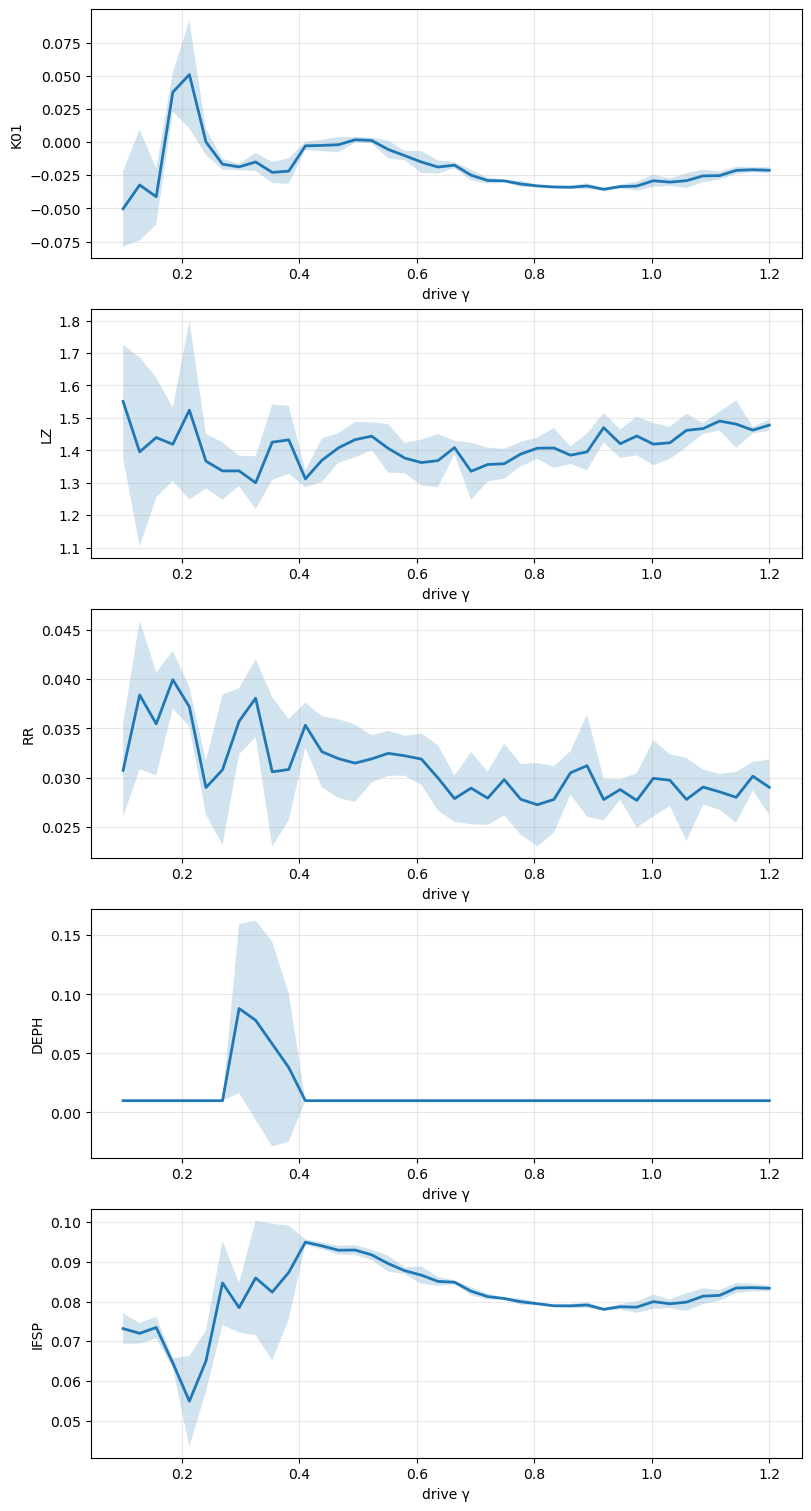

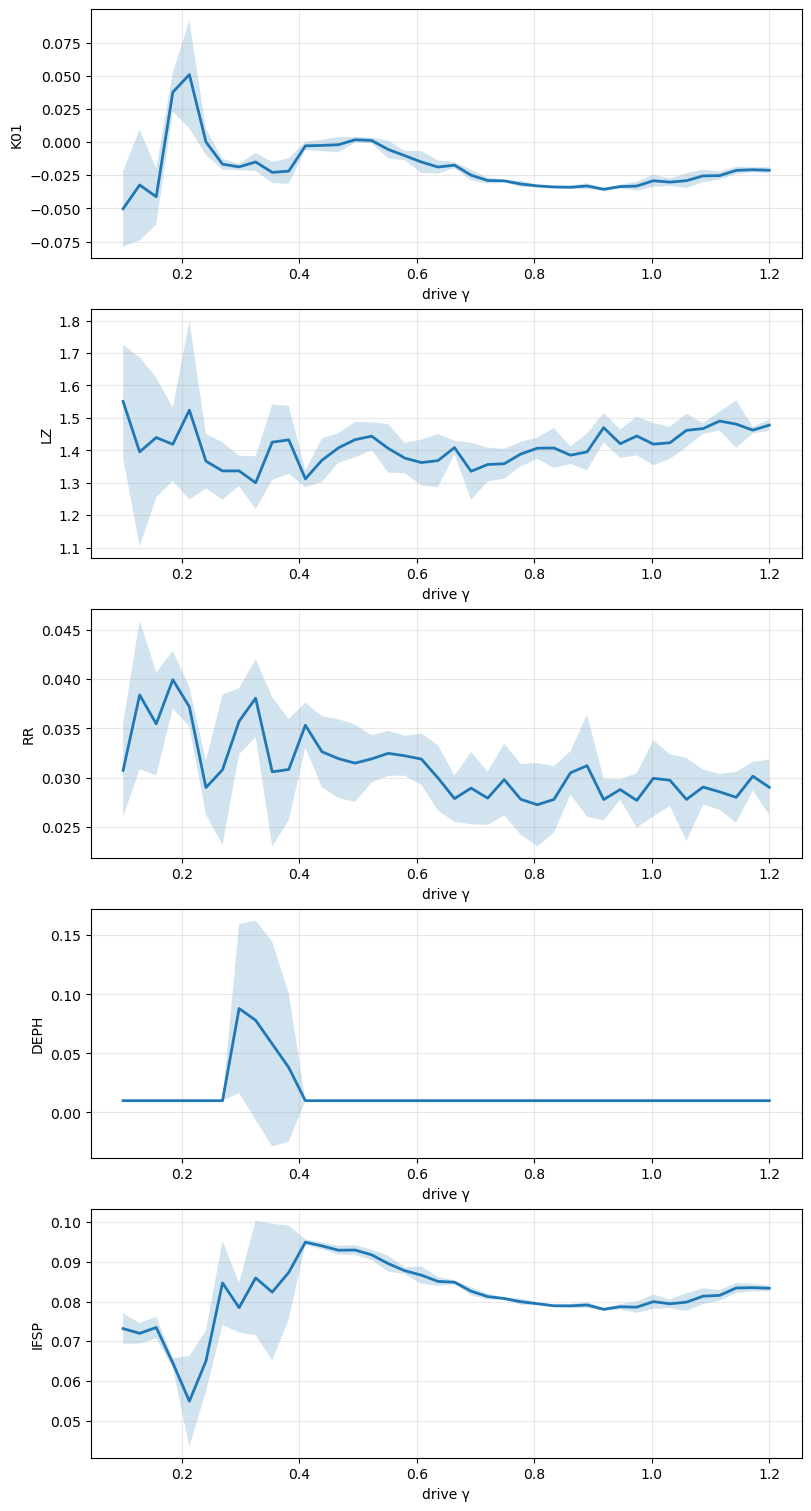

,gamma,K01_mean,K01_std,LZ_mean,LZ_std,RR_mean,RR_std,DEPH_mean,DEPH_std,IFSP_mean,IFSP_std,seed_mean,seed_std
0,0.100000,-0.050273,0.028367,1.550766,0.174591,0.030725,0.004721,0.01,0.0,0.073193,0.003846,2.0,1.581139
1,0.128205,-0.032344,0.041870,1.395210,0.291375,0.038397,0.007557,0.01,0.0,0.072007,0.002594,2.0,1.581139
2,0.156410,-0.041195,0.021136,1.439484,0.184665,0.035459,0.005243,0.01,0.0,0.073468,0.002710,2.0,1.581139
3,0.184615,0.037528,0.014696,1.418544,0.112913,0.039948,0.002929,0.01,0.0,0.064563,0.001216,2.0,1.581139
4,0.212821,0.050850,0.040639,1.523843,0.275924,0.037184,0.002007,0.01,0.0,0.054927,0.011386,2.0,1.581139


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Aggregate over seeds
agg = df.groupby('gamma', as_index=False).agg(['mean', 'std'])

# Robustly flatten MultiIndex columns
flat_cols = []
for col in agg.columns:
    if isinstance(col, tuple):
        # e.g., ('LLE','mean') -> 'LLE_mean'
        flat_cols.append('_'.join([c for c in col if c]))
    else:
        flat_cols.append(str(col))
agg.columns = flat_cols

# After flattening, the drive column is 'gamma' (not 'gamma_')
metrics = ['K01', 'LZ', 'RR', 'DEPH', 'IFSP']

# Plot trends (drop NaNs so lines don't break)
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, 3*len(metrics)), constrained_layout=True)
g = agg['gamma']  # x-axis

for i, m in enumerate(metrics):
    mu_col = f"{m}_mean"
    sd_col = f"{m}_std"
    if mu_col not in agg.columns:
        continue

    mu = agg[mu_col].to_numpy()
    sd = agg[sd_col].to_numpy()

    # mask finite values for plotting
    mask = np.isfinite(mu)
    axes[i].plot(g[mask], mu[mask], lw=2)
    axes[i].fill_between(g[mask], mu[mask] - sd[mask], mu[mask] + sd[mask], alpha=0.2, linewidth=0)
    axes[i].set_xlabel("drive γ")
    axes[i].set_ylabel(m)
    axes[i].grid(True, alpha=0.3)

fig, axes = plt.subplots(len(metrics), 1, figsize=(8, 3*len(metrics)), constrained_layout=True)
g = agg['gamma']

for i, m in enumerate(metrics):
    mu_col = f"{m}_mean"
    sd_col = f"{m}_std"
    if mu_col not in agg.columns:
        continue

    mu = agg[mu_col].to_numpy()
    sd = agg[sd_col].to_numpy()
    mask = np.isfinite(mu)

    axes[i].plot(g[mask], mu[mask], lw=2)
    axes[i].fill_between(g[mask], mu[mask] - sd[mask], mu[mask] + sd[mask], alpha=0.2, linewidth=0)
    axes[i].set_xlabel("drive γ")
    axes[i].set_ylabel(m)
    axes[i].grid(True, alpha=0.3)

import os
os.makedirs("results", exist_ok=True)
fig.savefig("results/metrics_vs_gamma.png", dpi=150, bbox_inches="tight")


plt.show()

agg.head()



## 6) Onset Detection via Piecewise Linear Fit

We fit a one‑breakpoint piecewise linear model to each metric vs. \(\gamma\) on the seed means.


In [7]:
breakpoints = {}
x = agg["gamma"].to_numpy()

for m in ['K01','LZ','RR','DEPH','IFSP']:
    y = agg.get(f"{m}_mean", None)
    if y is None:
        breakpoints[m] = np.nan
        continue
    y = y.to_numpy()

    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() < 6:
        breakpoints[m] = np.nan
        continue

    xb, yb = x[mask], y[mask]
    best = piecewise_linear_one_break(xb, yb)
    bp_gamma = xb[best['bp_idx']] if best['bp_idx'] is not None else np.nan
    breakpoints[m] = bp_gamma

breakpoints



{'K01': np.float64(0.24102564102564103),
 'LZ': np.float64(0.24102564102564103),
 'RR': np.float64(0.24102564102564103),
 'DEPH': np.float64(0.382051282051282),
 'IFSP': np.float64(0.2692307692307692)}

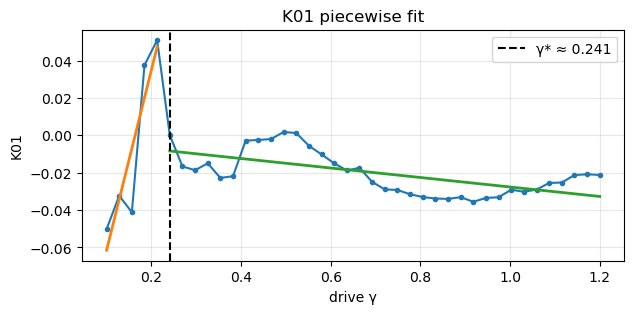

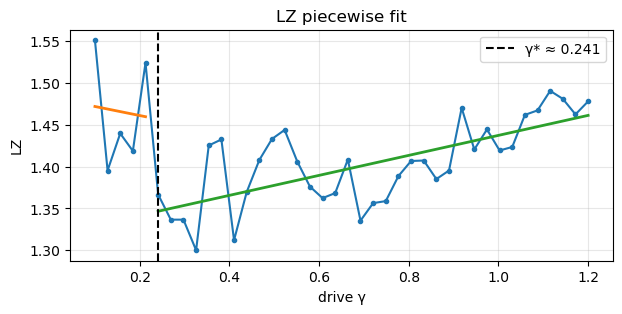

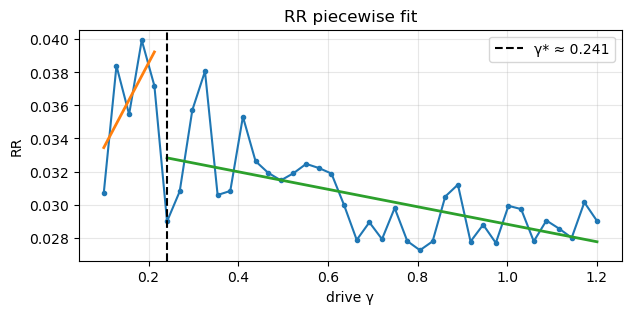

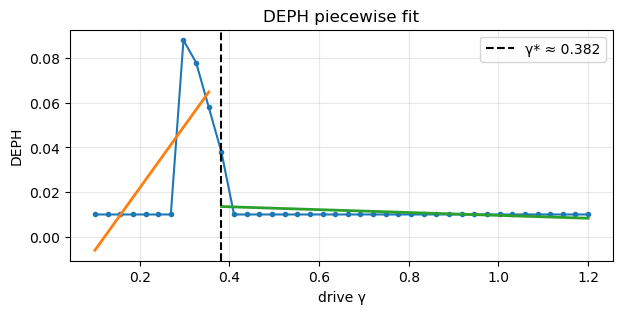

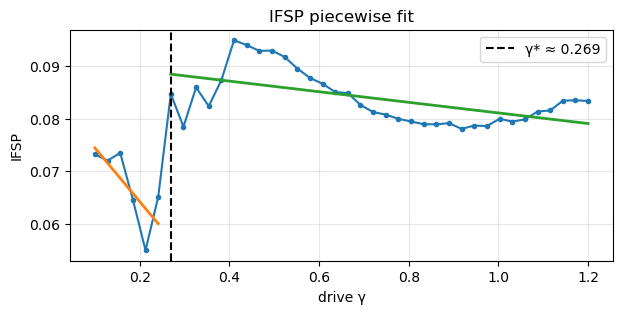

In [20]:
import os
os.makedirs("results", exist_ok=True)

for m in ['K01','LZ','RR','DEPH','IFSP']:
    y = agg.get(f"{m}_mean", None)
    if y is None:
        continue

    y = y.to_numpy()
    x = agg["gamma"].to_numpy()

    # mask finite
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() < 6:
        print(f"{m}: not enough finite points to fit.")
        continue

    xb, yb = x[mask], y[mask]
    best = piecewise_linear_one_break(xb, yb)

    plt.figure(figsize=(7,3))
    plt.plot(xb, yb, '-o', ms=3)

    # Draw fitted lines
    if best['bp_idx'] is not None:
        pl, pr = best['params']
        bp = best['bp_idx']

        # left segment
        xl = xb[:bp]
        yl_hat = pl[0]*xl + pl[1]
        plt.plot(xl, yl_hat, lw=2)

        # right segment
        xr = xb[bp:]
        yr_hat = pr[0]*xr + pr[1]
        plt.plot(xr, yr_hat, lw=2)

        # breakpoint line
        plt.axvline(xb[bp], ls='--', color='k', 
                    label=f"γ* ≈ {xb[bp]:.3f}")

        plt.legend(loc='best')

    plt.title(f"{m} piecewise fit")
    plt.xlabel("drive γ")
    plt.ylabel(m)
    plt.grid(True, alpha=0.3)

    # --- SAVE THE FIGURE ---
    plt.savefig(f"results/piecewise_{m}.png", 
                dpi=150, 
                bbox_inches="tight")

    plt.show()




## 7) Choose Three Drive Levels for Surrogates

We pick **low**, **near-onset**, and **high** \(\gamma\). The onset is estimated as the **median** breakpoint across metrics.


In [9]:

# median breakpoint across metrics
bp_vals = np.array([v for v in breakpoints.values() if np.isfinite(v)])
if len(bp_vals) == 0:
    gamma_onset = float(GAMMA_GRID[N_GAMMA//2])
else:
    gamma_onset = float(np.median(bp_vals))

gamma_low  = float(GAMMA_GRID[max(0, int(0.15*N_GAMMA))])
gamma_high = float(GAMMA_GRID[min(N_GAMMA-1, int(0.85*N_GAMMA))])

gamma_low, gamma_onset, gamma_high

(0.2692307692307692, 0.24102564102564103, 1.058974358974359)


## 8) Surrogate‑Data Nonlinearity Test (IAAFT)

For each chosen \(\gamma\), we generate IAAFT surrogates and compare metric values against the real series. We report **p‑values** as the percentile of the real metric relative to the surrogate distribution.


In [10]:

def percentile_pvalue(real, surrogates, tail='greater'):
    s = np.sort(surrogates)
    if tail == 'greater':
        # P(X_surr >= real)
        p = 1.0 - np.searchsorted(s, real, side='right') / len(s)
    else:
        # P(X_surr <= real)
        p = np.searchsorted(s, real, side='left') / len(s)
    return float(p)

def metric_vector_for_gamma(gamma, n_series=5):
    vals = {k: [] for k in ['K01','LZ','RR','DEPH','IFSP']}
    for s in range(n_series):
        t, x = simulate_duffing(gamma, seed=800 + s)
        m = compute_all_metrics(x, DT)
        for k in vals: vals[k].append(m[k])
    return {k: np.array(v) for k,v in vals.items()}

gamma_triplet = [gamma_low, gamma_onset, gamma_high]
surrogate_summary = {}

for g in gamma_triplet:
    mv = metric_vector_for_gamma(g, n_series=5)
    pool = {k: [] for k in mv.keys()}

    for s in range(5):
        t, x = simulate_duffing(g, seed=900 + s)
        S = iaaft_surrogates(x, n_surr=N_SURR, iters=50)

        for k in mv.keys():
            if k == 'K01':
                idx = np.linspace(0, len(S)-1, num=min(50, len(S)), dtype=int)
                vals = [zero_one_test(S[i], c_samples=K_C_SAMPLES//2) for i in idx]
            elif k == 'LZ':
                vals = [lz_complexity(quantize_to_uint8(si)) for si in S]
            elif k == 'RR':
                vals = [recurrence_rate(si, m=EMBED_M, tau=None, radius_mult=REC_RADIUS_MULT) for si in S]
            elif k == 'DEPH':
                vals = [phase_dephasing_half_life(si, DT) for si in S]
            elif k == 'IFSP':
                vals = [if_spread(si, DT) for si in S]
            pool[k].extend(vals)

    pvals = {}
    tails = dict(K01='greater', LZ='greater', RR='less', DEPH='less', IFSP='greater')
    for k in mv.keys():
        real_mean = np.nanmean(mv[k])
        surr = np.array(pool[k])
        surr = surr[np.isfinite(surr)]
        if len(surr)==0 or not np.isfinite(real_mean):
            p = np.nan
        else:
            p = percentile_pvalue(real_mean, surr, tail=tails[k])
        pvals[k] = p
    surrogate_summary[g] = pvals

surrogate_summary


{0.2692307692307692: {'K01': 0.8200000000000001,
  'LZ': 1.0,
  'RR': 1.0,
  'DEPH': 0.0,
  'IFSP': 0.98},
 0.24102564102564103: {'K01': 0.788,
  'LZ': 1.0,
  'RR': 1.0,
  'DEPH': 0.0,
  'IFSP': 1.0},
 1.058974358974359: {'K01': 0.964,
  'LZ': 1.0,
  'RR': 1.0,
  'DEPH': 0.0,
  'IFSP': 1.0}}


## 9) Summary Figures

- Trend plots with seed‑mean and std‑bands (already shown).
- Piecewise fits with breakpoints (already shown).
- Surrogate distributions vs. real means at three \(\gamma\) levels.


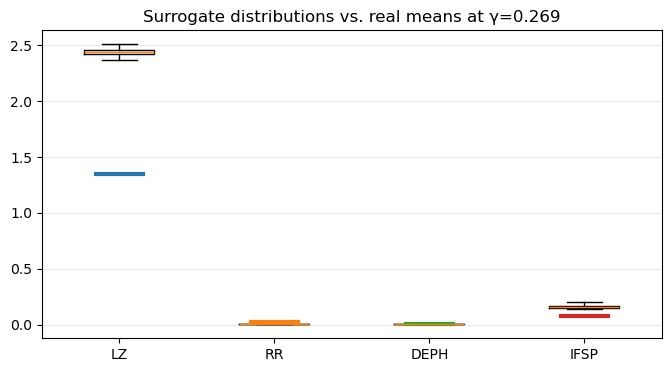

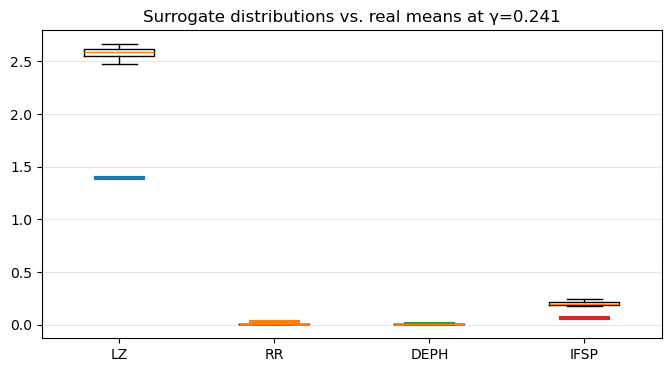

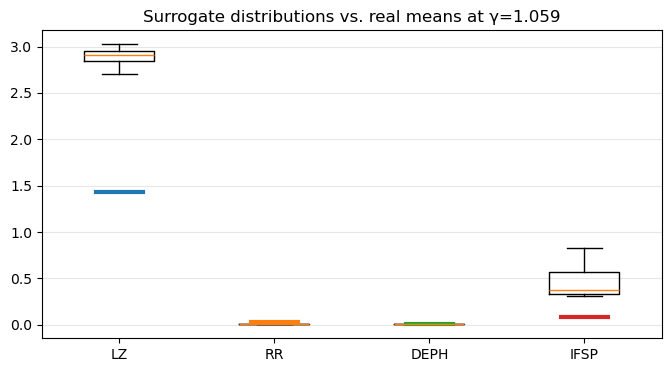

In [22]:
import os
os.makedirs("results", exist_ok=True)

# Boxplots of surrogate distributions with real means overlaid
for g in gamma_triplet:
    # regenerate pooled surrogate distributions (reuse from earlier cell logic compactly)
    t, x = simulate_duffing(g, seed=777)
    S = iaaft_surrogates(x, n_surr=60, iters=40)

    surrd = {}
    for k in ['LZ','RR','DEPH','IFSP']:
        if k == 'LZ':
            vals = [lz_complexity(quantize_to_uint8(si)) for si in S]
        elif k == 'RR':
            vals = [recurrence_rate(si, m=EMBED_M, tau=None, radius_mult=REC_RADIUS_MULT) for si in S]
        elif k == 'DEPH':
            vals = [phase_dephasing_half_life(si, DT) for si in S]
        elif k == 'IFSP':
            vals = [if_spread(si, DT) for si in S]
        surrd[k] = np.array(vals)

    # real metric means for this gamma
    mv = metric_vector_for_gamma(g, n_series=5)
    real_means = {k: np.nanmean(v) for k,v in mv.items()}

    # prepare boxplot data
    labels = list(surrd.keys())
    data = [surrd[k] for k in labels]

    plt.figure(figsize=(8,4))
    plt.boxplot(data, tick_labels=labels, showfliers=False)

    # overlay real means as thick horizontal segments
    for i, k in enumerate(labels, start=1):
        plt.plot([i-0.15, i+0.15], [real_means[k], real_means[k]], lw=3)

    plt.title(f"Surrogate distributions vs. real means at γ={g:.3f}")
    plt.grid(True, axis='y', alpha=0.3)

    # save and show
    plt.savefig(f"results/surrogates_gamma_{g:.3f}.png",
                dpi=150,
                bbox_inches="tight")
    plt.show()



## 10) Outputs & Notes

**Outputs in this notebook:** figures, breakpoint table, surrogate p‑values dict.

**Reproducibility notes:**
- Seeds are fixed where indicated; change the master seed at the top for full reruns.
- If you extend runtime, consider increasing `T_KEEP`, `N_GAMMA`, and `N_SEEDS`.
- For publication, export figures to files and record exact parameter values and seeds.


In [12]:

import pandas as pd
bp_table = pd.DataFrame({'metric': list(breakpoints.keys()),
                         'gamma_break': [breakpoints[k] for k in breakpoints]})
bp_table

,metric,gamma_break
0,K01,0.241026
1,LZ,0.241026
2,RR,0.241026
3,DEPH,0.382051
4,IFSP,0.269231


In [23]:

# Save results
import os
os.makedirs('results', exist_ok=True)
bp_table.to_csv('results/duffing_breakpoints.csv', index=False)



import json
with open('results/duffing_surrogate_pvals.json','w') as f:
    json.dump(surrogate_summary, f, indent=2)


print("Saved: /mnt/data/duffing_breakpoints.csv and /mnt/data/duffing_surrogate_pvals.json")




Saved: /mnt/data/duffing_breakpoints.csv and /mnt/data/duffing_surrogate_pvals.json



## 11) Environment Info


In [16]:

import sys, numpy, scipy, matplotlib
print("Python", sys.version)
print("NumPy", numpy.__version__)
import scipy as sp
print("SciPy", sp.__version__)
print("Matplotlib", matplotlib.__version__)

Python 3.10.19 | packaged by conda-forge | (main, Oct 22 2025, 22:46:36) [Clang 19.1.7 ]
NumPy 2.2.6
SciPy 1.15.2
Matplotlib 3.10.7
